# Les incendies en Turquie entre 2000 et 2021.
## Projet Python

***
### Git : 
Travail versioné suivant le graph git suivant.

![gitgraph](gitgraph.png)
### Lien GitHub : 
https://github.com/EnzoReg/Project-Turkey-Fire

***
## Environnement de travail : 
#### Outils utilisés
- Python 3.12.0
- Environement virtuel avec divers modules installé _(voir fichier Turkey_requirements.txt)_ 
- Notebook.ipynb (Jupiter Notebook)
- Kernel jupiter instalé dans l'environement virtuel pour le Jupiter Notebook

_L'environnement virtuel et le kernel Jupyter instalé dans celui-ci sont optionel. Une instalation classique peut trés bien fonctionner._

#### Import des modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp      #Non utilisé en soi mais indispensable pour le module scikit-learn

#folium
import folium
from folium.plugins import FastMarkerCluster
from folium.plugins import HeatMap

#scikit-learn module
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

***
## Récupération des données :

Les données traitées ici sont dans un fichier CSV (Comma Separated Values). Elles représentes les feux de forêts survenues en Turquie de 2000 à 2021. 
- Plusieurs variables sont représentés : 
    - **latitude and longitude**: Position géographique du feu.
    - **brightness**: Température de luminosité mesurée en kelvins
  - **scan and track**: Résolution spatiale
  - **acq_date**: Date de feu
  - **acq_time**: Heure d’acquisition du satellite (en UTC). _Donnée brute qui sera post-traité pour etre plus lisible._
  - **satellite**: Detection par les satellites TERRA ou AQUA
  - **instrument**: MODIS. C'est l'unique instrument d'observation utilisé dans ce jeu de données. MODIS est embarqué dans les satellites TERRA et AQUA. La combinaison de ces deux satellites, qui ont une trajectoire orbitale inverse, génère une couverture complète tout les 1 à 2 jours.
  - **confidence**: Indicateur de qualité
  - **version**: Traitement de la collecte et de la source des données
  - **bright_t31**: Température de luminosité mesurée en kelvins
  - **frp**: Puissance radiative du feu
  - **daynight**: D pour feu diurne, N pour feu nocturne
  - **type**: 0 pour un feu de végétation présumé, 1 pour un volcan actif, 2 pour d'autres sources terrestres statiques et 3 pour une détection en mer

- Création de la base de données _"data"_ à partir du fichier _2000-2021_SINGLE_TURKEY_FIRE_M-C61_214067.csv_ fourni.
- Nettoyage des données selon la variable "confidence" (la valeure 50 choisi est arbritraire et représente un taux de fausses données d'environ 19%).

In [2]:
data= pd.read_csv('2000-2021_SINGLE_TURKEY_FIRE_M-C61_214067.csv')
data = data[data['confidence'] > 50]
print("Aperçu de la base de données créée :\n")
print(data.head())

C:\Users\Surface\AppData\Local\Temp\ipykernel_4328\2850556367.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data= pd.read_csv('2000-2021_SINGLE_TURKEY_FIRE_M-C61_214067.csv')


Aperçu de la base de données créée :

   latitude  longitude  brightness  scan  track    acq_date  acq_time  \
0   36.8527    35.3594       306.0   2.1    1.4  2000-11-01       815   
1   40.5441    35.1786       307.8   1.1    1.0  2000-11-02       857   
3   40.5421    35.1909       310.0   1.1    1.0  2000-11-02       857   
6   39.1096    33.9391       324.5   1.0    1.0  2000-11-02       858   
7   39.1981    32.4182       308.9   1.0    1.0  2000-11-02       858   

  satellite instrument  confidence version  bright_t31   frp daynight  type  
0     Terra      MODIS          60    6.03       294.4  13.2        D   0.0  
1     Terra      MODIS          66    6.03       296.0   5.8        D   0.0  
3     Terra      MODIS          69    6.03       296.1   7.3        D   0.0  
6     Terra      MODIS          82    6.03       294.4  20.2        D   0.0  
7     Terra      MODIS          64    6.03       294.6   6.1        D   0.0  


- Uniformisation des valeurs de la colonne "acq_time"
- Conversion de la colonne en type "time".

In [3]:
data.rename(columns={'acq_time': 'acq_time_brute'}, inplace=True)
data['acq_time_brute'] = data['acq_time_brute'].apply(lambda x: '000' + str(x) if len(str(x)) == 1 else str(x))
data['acq_time_brute'] = data['acq_time_brute'].apply(lambda x: '00' + str(x) if len(str(x)) == 2 else str(x))
data['acq_time_brute'] = data['acq_time_brute'].apply(lambda x: '0' + str(x) if len(str(x)) == 3 else str(x))
data['acq_time_brute'] = pd.to_datetime(data['acq_time_brute'], format='%H%M')
data['acq_time'] = data['acq_time_brute'].dt.time
data.drop(columns=['acq_time_brute'], inplace=True)
print(data.head())

   latitude  longitude  brightness  scan  track    acq_date satellite  \
0   36.8527    35.3594       306.0   2.1    1.4  2000-11-01     Terra   
1   40.5441    35.1786       307.8   1.1    1.0  2000-11-02     Terra   
3   40.5421    35.1909       310.0   1.1    1.0  2000-11-02     Terra   
6   39.1096    33.9391       324.5   1.0    1.0  2000-11-02     Terra   
7   39.1981    32.4182       308.9   1.0    1.0  2000-11-02     Terra   

  instrument  confidence version  bright_t31   frp daynight  type  acq_time  
0      MODIS          60    6.03       294.4  13.2        D   0.0  08:15:00  
1      MODIS          66    6.03       296.0   5.8        D   0.0  08:57:00  
3      MODIS          69    6.03       296.1   7.3        D   0.0  08:57:00  
6      MODIS          82    6.03       294.4  20.2        D   0.0  08:58:00  
7      MODIS          64    6.03       294.6   6.1        D   0.0  08:58:00  


***
## Présentation des données :
#### Variables quantitatives
- Calcule des statistiques des variables 

In [4]:
Quantitative_var_summary = data.describe()
print("Statistiques descriptives pour les variables quantitatives :\n")
print(Quantitative_var_summary)

Statistiques descriptives pour les variables quantitatives :

            latitude      longitude     brightness           scan  \
count  170950.000000  170950.000000  170950.000000  170950.000000   
mean       38.050242      36.021717     325.202763       1.521844   
std         1.223203       4.143690      15.963652       0.734580   
min        35.822100      25.738500     302.100000       1.000000   
25%        37.107800      33.314808     313.300000       1.000000   
50%        37.673400      35.895400     324.000000       1.200000   
75%        38.833875      39.884475     333.200000       1.700000   
max        42.033000      44.796700     503.530000       4.820000   

               track     confidence     bright_t31            frp  \
count  170950.000000  170950.000000  170950.000000  170950.000000   
mean        1.184281      73.342767     303.311976      34.398123   
std         0.228538      13.431473      10.080697      73.133218   
min         1.000000      51.000000     

- Visualitation de la distribution des variables

Distribution des variables quantitatives


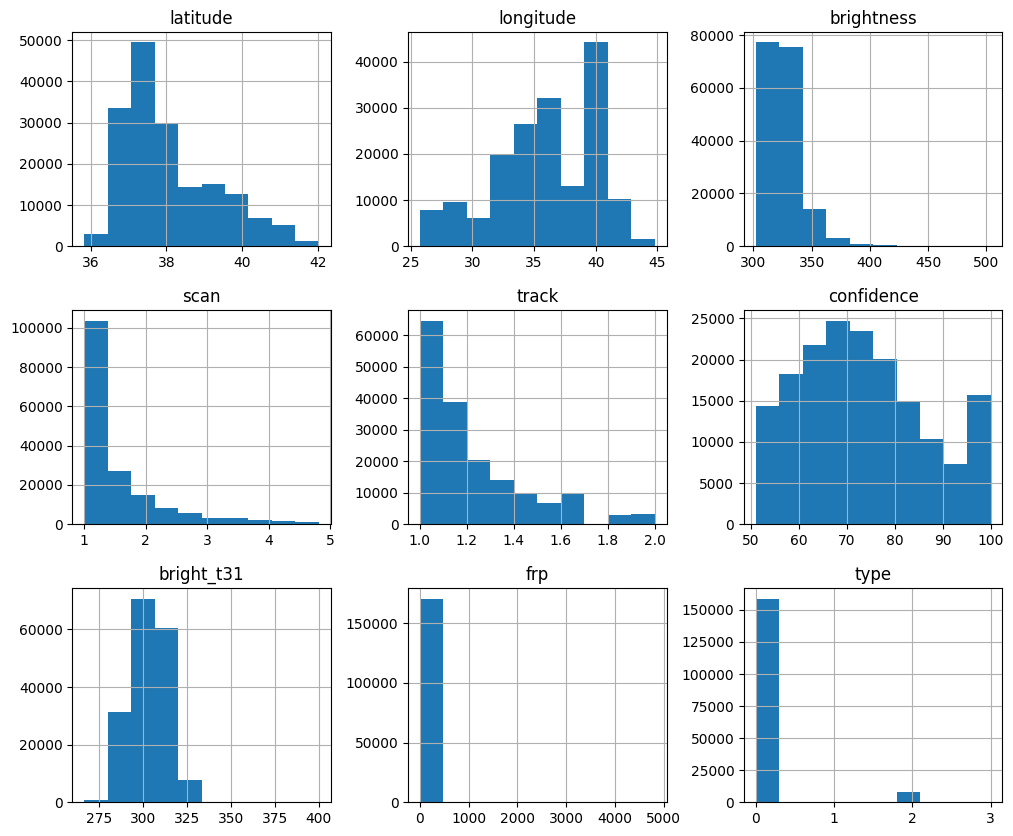

In [5]:
data.hist(figsize=(12, 10))
print("Distribution des variables quantitatives")
plt.show()

- Visualisation de la relation entre les varriables via une mattrice de corrélation


Visualisation de la matrice de corrélation :


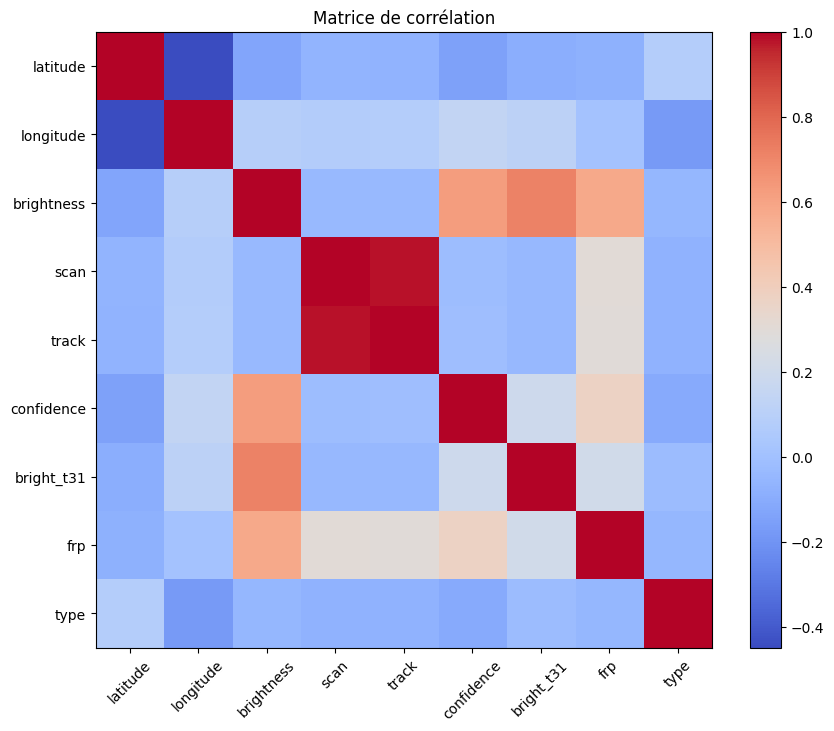

In [6]:
print("\nVisualisation de la matrice de corrélation :")
colonnes_non_quantitatives = ['acq_date', 'acq_time', 'satellite', 'instrument', 'version', 'daynight']
data_quantitative = data.drop(columns=colonnes_non_quantitatives, errors='ignore')
corr_matrix = data_quantitative.corr()
plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title("Matrice de corrélation")
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
plt.show()

- Visualisation de la répartition des variables

Répartition des variables quantitatives


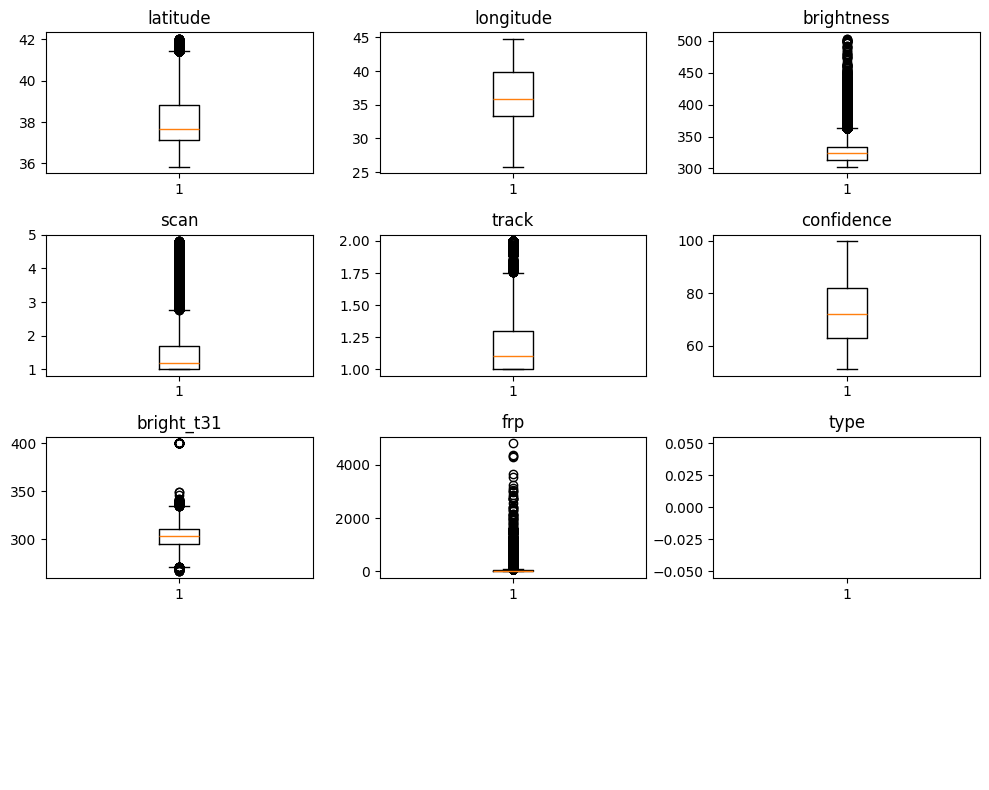

In [7]:
quantitative_variables = data.select_dtypes(include=np.number)
print('Répartition des variables quantitatives')
plt.figure(figsize=(10,8))
plt.axis('off')
for i, column in enumerate(quantitative_variables.columns):
    plt.subplot(4, 3, i + 1)
    plt.boxplot(data[column])
    plt.title(column)
plt.tight_layout()
plt.show()

#### Variable qualitatives
- Nombres d'occurences de chaques variable 

In [8]:
categorical_variables = data.select_dtypes(include='object')
for column in categorical_variables.columns:
    print("\nNombre d'occurrences pour la variable '{}' :".format(column))
    print(data[column].value_counts())


Nombre d'occurrences pour la variable 'acq_date' :
acq_date
2021-07-29    550
2009-09-29    409
2009-09-24    388
2009-10-03    379
2011-10-07    360
             ... 
2006-04-09      1
2016-12-17      1
2006-04-07      1
2006-04-04      1
2000-11-01      1
Name: count, Length: 5901, dtype: int64

Nombre d'occurrences pour la variable 'satellite' :
satellite
Terra    91274
Aqua     79676
Name: count, dtype: int64

Nombre d'occurrences pour la variable 'instrument' :
instrument
MODIS    170950
Name: count, dtype: int64

Nombre d'occurrences pour la variable 'version' :
version
6.03      159183
6.03        7313
6.1NRT      4454
Name: count, dtype: int64

Nombre d'occurrences pour la variable 'daynight' :
daynight
D    139618
N     31332
Name: count, dtype: int64

Nombre d'occurrences pour la variable 'acq_time' :
acq_time
10:48:00    2946
08:39:00    2774
10:42:00    2752
08:20:00    2680
08:45:00    2563
            ... 
00:51:00       1
20:17:00       1
00:29:00       1
00:38:00      

- Relations entre les différentes variables

In [9]:
cross_tab1 = pd.crosstab(data['type'], data['daynight'])
print("Tableau croisé entre type et daynight :")
print(cross_tab1)

cross_tab2 = pd.crosstab(data['satellite'], data['daynight'])
print("\nTableau croisé entre satellite et daynight :")
print(cross_tab2)

cross_tab3 = pd.crosstab(data['satellite'], data['type'])
print("\nTableau croisé entre satellite et type :")
print(cross_tab3)

Tableau croisé entre type et daynight :
daynight       D      N
type                   
0.0       130617  28116
2.0         6557   1146
3.0           33     27

Tableau croisé entre satellite et daynight :
daynight       D      N
satellite              
Aqua       72781   6895
Terra      66837  24437

Tableau croisé entre satellite et type :
type         0.0   2.0  3.0
satellite                  
Aqua       74358  3338   13
Terra      84375  4365   47


- Evolution des feux par ans entre 2000 et 2021

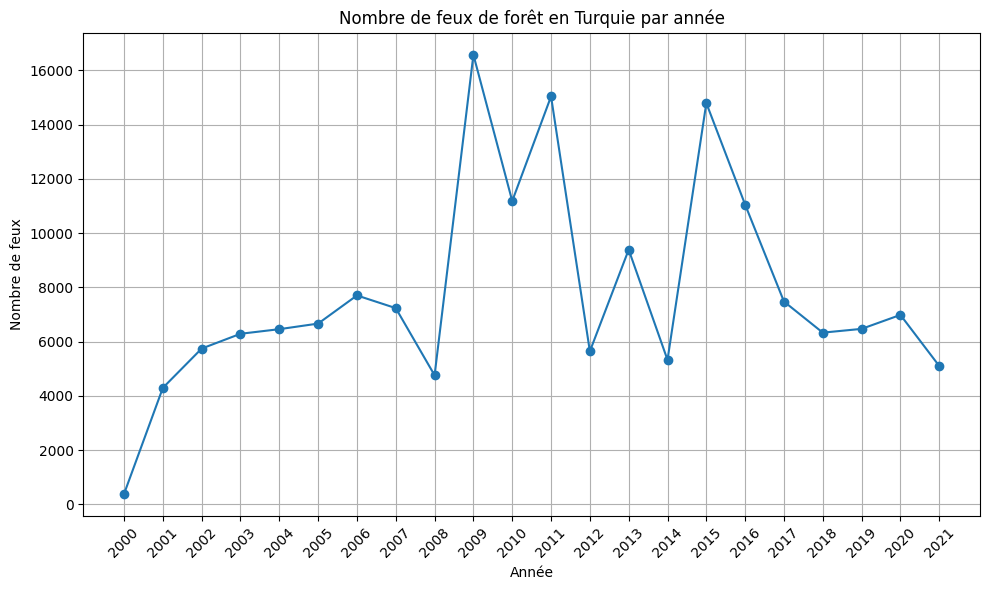

In [10]:
# Conversion de la colonne 'acq_date' en format de date
data['acq_date'] = pd.to_datetime(data['acq_date'])

# Extraction de l'année à partir de la colonne 'acq_date'
data['year'] = data['acq_date'].dt.year

# Comptage du nombre de feux par année
fires_per_year = data.groupby('year').size()

# Création du graphique
plt.figure(figsize=(10, 6))
plt.plot(fires_per_year.index, fires_per_year.values, marker='o', linestyle='-')
plt.title('Nombre de feux de forêt en Turquie par année')
plt.xlabel('Année')
plt.ylabel('Nombre de feux')
plt.grid(True)
plt.xticks(fires_per_year.index, rotation=45)
plt.tight_layout()
plt.show()

- Histogramme par mois

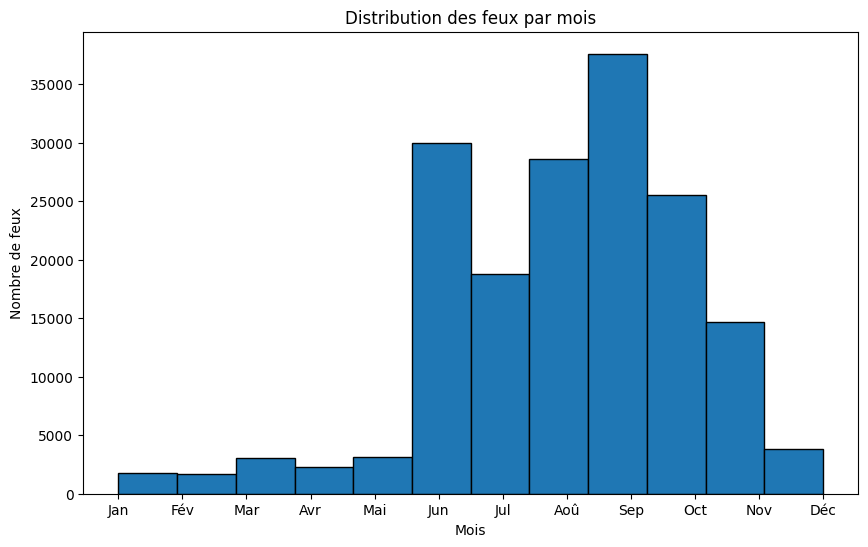

In [11]:
data['month'] = data['acq_date'].dt.month

# Créer un histogramme du nombre de feux par mois
plt.figure(figsize=(10, 6))
data['month'].plot(kind='hist', bins=12, edgecolor='black')
plt.title('Distribution des feux par mois')
plt.xlabel('Mois')
plt.ylabel('Nombre de feux')
plt.xticks(range(1, 13), ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun', 'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc'])
plt.show()

- Analyse de séries temporelles

C:\Users\Surface\AppData\Local\Temp\ipykernel_4328\2448418175.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data.resample('M').size().plot()


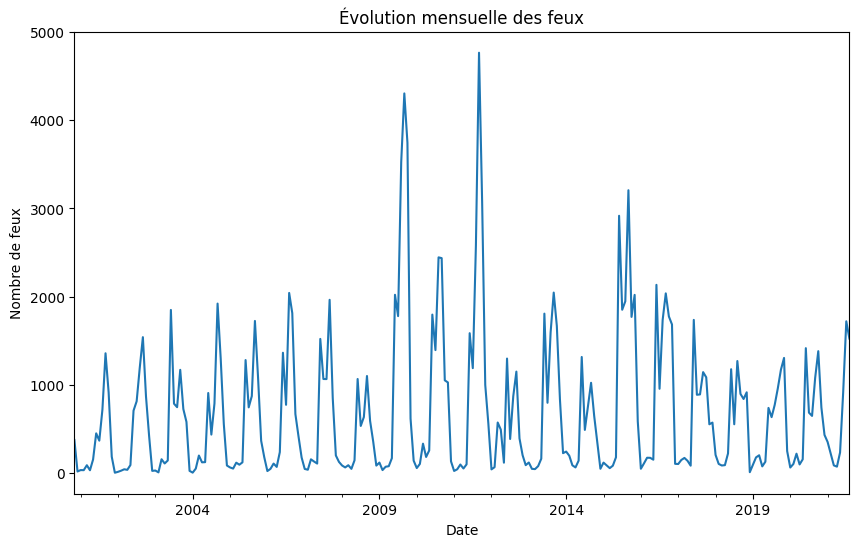

In [12]:
data.set_index('acq_date', inplace=True)

# Tracer la série temporelle du nombre de feux par mois
plt.figure(figsize=(10, 6))
data.resample('M').size().plot()
plt.title('Évolution mensuelle des feux')
plt.xlabel('Date')
plt.ylabel('Nombre de feux')
plt.show()

***
## Complément des données de la colonne "type" manquantes via de l'IA par classification :
_Temps de generation des données manquantes = 1m15 environ_

- Choix de l'algorythme d'IA : 
    - **Random Forest Classifier** : Algorythme le plus basique utilisé dans les cas où la base de données n'est pas trop volumineuse et ou le temps d'entrainement doit etre assez rapide.
    - **Gradient Boosting Machine (GBM)** : Utilisé dans de grands ensembles de données, donnes des resultats plus précis que le precedent mais au détriment d'un temps d'entrainement plus long.
    - **Support Vector Machine (SVM)** : Utilisé lors d'ensemble de données linéaire ou de petite taille.
    - **Reseaux de neurones convolutifs (CNN)** : Alogrythme utilisé pour travaillé avec des images et en extraires des données.
    - **Réseaux de neurones artificiels (ANN)** : Utilisé pour les ensembles de données non linéaires les plus complèxes, mais il nécessite beaucoup de données et un temps d'entrainement beaucoup plus long.

Pour notre cas, nous avons une base de données de taille moyenne, l'interpretabilité du resultat souhaité est basique, et le temps d'entrainement doit etre assez court pour la demonstration lors de la soutenance (cette dernière exigence n'alterera pas la précision du resultat). 

On choisi donc d'utiliser **Random Forest Classifier**.
***

- Définition des colonnes catégorielles et numériques

In [13]:
qualitative_columns = ['satellite', 'daynight']
numerical_columns = ['latitude', 'longitude', 'brightness', 'scan', 'track', 'confidence', 'bright_t31', 'frp']

- Création des transformateurs pour le prétraitement des données

In [14]:
qualitative_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), #remplisseur de trou avec des valeurs les plus frequentes
        ('onehot', OneHotEncoder(handle_unknown='ignore')) #pour convertir les variables qualitatives en nombres arbitraires 
    ]
)
numerical_transformer = SimpleImputer(strategy='mean') #remplisseur de trou avec des valeurs moyenne

- Création d'un préprocesseur pour traiter les différentes colonnes

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', qualitative_transformer, qualitative_columns),
        ('num', numerical_transformer, numerical_columns)
    ]
)

- Définition du modele d'IA complet avec le préprocesseur et le modèle de classification

_Algorythme d'IA choisi : RandomForestClassifier_

In [16]:
complet_modele = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier())
    ]
)

- Séparation des données en ensemble d'entraînement et ensemble de test

_Ensemble d'entrainement comportant les lignes complètes de la colonne "type" + toutes les autres colonnes_

In [17]:
train_data = data.dropna(subset=['type'])
X_train = train_data.drop(columns=['type'])
y_train = train_data['type']

_Ensemble de prediction comportant les lignes vides de la colonne "type"_

In [18]:
predict_data = data[data['type'].isnull()]
X_predict = predict_data.drop(columns=['type'])

- Entraînement du modèle

In [19]:
complet_modele.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['satellite', 'daynight']),
                                                 ('num', SimpleImputer(),
                                                  ['latitude', 'longitude',
                                                   'brightness', 'scan',
                                                   'track', 'confidence',
                                                   'bright_t31', 'frp'])])),
                ('classifier', RandomForestClassifier())])

- Prédiction des valeurs manquantes

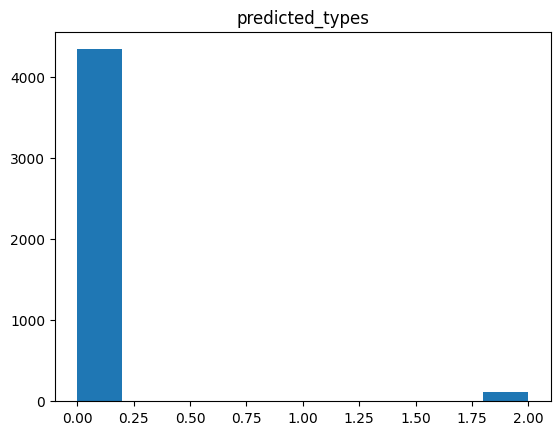

In [20]:
predicted_types = complet_modele.predict(X_predict)
plt.hist(predicted_types)
plt.title("predicted_types")
plt.show()

- Remplacement des valeurs manquantes par celles prédites

In [21]:
data.loc[data['type'].isnull(), 'type'] = predicted_types

***
## Clustering spatial
_Temps d'execution d'environ 11s_

- Sélectionner les colonnes de latitude et de longitude comme coordonnées spatiales

In [22]:
ensemble_spatial = data[['latitude', 'longitude']]

- Choix du nombre de clustres

In [23]:
n_clusters = 8

- Initialisation de l'algorithme K-Means avec le nombre de clusters spécifié

In [24]:
kmeans = KMeans(n_clusters=n_clusters)

- Entrainement de l'algorithme

In [25]:
kmeans.fit(ensemble_spatial)

KMeans()

- Obtenir les étiquettes de cluster pour chaque point de données

In [26]:
labels = kmeans.labels_

- Obtenir les coordonnées des centroides de cluster

In [27]:
centroids = kmeans.cluster_centers_

- Visualisation des clusters

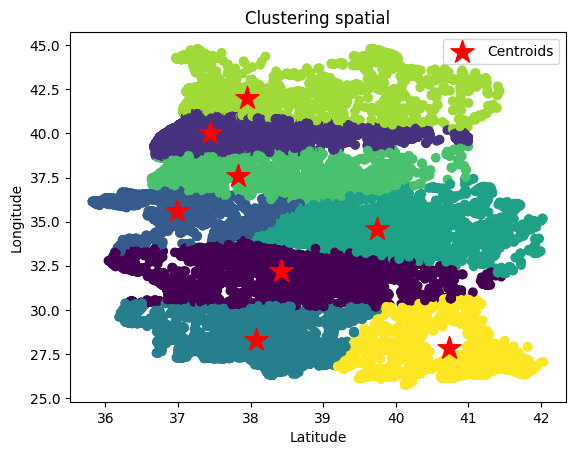

In [28]:
plt.scatter(ensemble_spatial['latitude'], ensemble_spatial['longitude'], c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=300, c='red', label='Centroids')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Clustering spatial')
plt.legend()
plt.show()

- Visualisation via une carte satellite (Markers et HeatMap temporelle)

In [29]:
map2 = folium.Map(location=[data['latitude'].mean(), data['longitude'].mean()], zoom_start=5)
cluster_data = list(zip(data['latitude'], data['longitude']))
FastMarkerCluster(cluster_data).add_to(map2)
heatmap_data = data[['latitude', 'longitude', 'acq_date']]
heatmap_data = heatmap_data.dropna()
heat_data = heatmap_data[['latitude', 'longitude']].values.tolist()
map2.add_child(HeatMap(heat_data))
folium.LayerControl().add_to(map2)
map2



KeyError: "['acq_date'] not in index"

- Generation d'un fichier .html standalone (ouvrable avec un navigateur) où visualiser les cartes satellite.

In [ ]:
map1.save('map1.html')
map2.save('map2.html')

***
## Clustering temporel :
_Temps d'execution d'environ 13s_
- Selection des données utiles à partir de la colonne "acq_date"

In [ ]:
data['acq_date'] = pd.to_datetime(data['acq_date'])
data['year'] = data['acq_date'].dt.year
data['month'] = data['acq_date'].dt.month
X = data[['year', 'month']]

- Définition du nombre de clusters à rechercher

In [ ]:
n_clusters = 8

- Définition et entrainement de l'algorithme K-means

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X)

- Récupération des labels de clusters et visulalisation

In [ ]:
labels = kmeans.labels_
plt.figure(figsize=(10, 6))
for cluster_label in range(n_clusters):
    cluster_data = X[labels == cluster_label]
    plt.scatter(cluster_data['year'], cluster_data['month'], label=f'Cluster {cluster_label + 1}', s=100, cmap='viridis')
plt.title('Clustering temporel')
plt.xlabel('Année')
plt.ylabel('Mois')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()